In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 8.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [5]:
original_samples = pd.read_csv('/gdrive/MyDrive/pr/unbalanced.csv')

In [6]:
labeled_data_original = pd.read_csv('/gdrive/MyDrive/pr/labeled_data_original.csv',sep='\t')
labeled_data_firstround = pd.read_csv('/gdrive/MyDrive/pr/labeled_data_firstround.csv',sep='\t')

In [7]:
labeled_data_original.drop(labeled_data_original.columns[[0]], axis = 1, inplace = True)

In [8]:
labeled_data_original

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
994,995,ইমান সুখ,non_depressive
995,996,"সুপ্ৰভাত ,",non_depressive
996,997,নিরন্তর গণতন্ত্রের গলা টিপছে মমতা বন্দ্যোপাধ্য...,non_depressive
997,998,"যৌতুকের জন্য যদি স্ত্রীকে পেটানো হয় তাহলে , দ...",non_depressive


In [9]:
labeled_data_firstround.drop(labeled_data_firstround.columns[[0]], axis = 1, inplace = True)

In [10]:
labeled_data_firstround

,ID,Texts,labels
0,1020,"অরন্যদেব ছবিতে যে ছিল আমার কন্যা , সে আজ থেকে ...",non_depressive
1,1153,আমিই কি একজন ? যে লজ্জার কারণে কারো সাথে ভিডিও...,non_depressive
2,1162,ধন্যবাদ ও সবাই কে সময় মত রক্ত দেয়াতে আপুর বো...,non_depressive
3,1173,আমার এ ঘর ভাঙিয়াছে যে আমি বাধি তার ঘর আপন করি...,depressive
4,1311,বিএনপি মহাসচিব মির্জা ফখরুল ইসলাম আলমগীর দাবি ...,non_depressive
...,...,...,...
182,3859,"এদের কাছে কোন জিনিস না নিয়ে যাবেন্নাহ , কেননা...",non_depressive
183,3880,"আয় বিজেপি দেখে যা , দেখবি যত জ্বলবি তত !",depressive
184,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,depressive
185,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",depressive


In [11]:
all_labeled = pd.DataFrame()

In [12]:
all_labeled = pd.concat([labeled_data_original, labeled_data_firstround])

In [13]:
all_labeled

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
182,3859,"এদের কাছে কোন জিনিস না নিয়ে যাবেন্নাহ , কেননা...",non_depressive
183,3880,"আয় বিজেপি দেখে যা , দেখবি যত জ্বলবি তত !",depressive
184,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,depressive
185,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",depressive


In [14]:
unlabeled_remained = original_samples.loc[~original_samples['ID'].isin(all_labeled['ID'])]

In [15]:
unlabeled_remained

,ID,Texts,labels
999,1000,"হ্যালো ফ্রেন্ডস আমি দিশা , সবার নাকাব মুভি টা ...",non_depressive
1000,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,depressive
1001,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,non_depressive
1002,1003,"সব ভালোবাসা প্রেম নয় , কিছু ভালোবাসা বন্ধুত্ব...",non_depressive
1003,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",non_depressive
...,...,...,...
3909,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,non_depressive
3910,3911,আমার মেয়ের জন্য একটি সুন্দর নাম দিন । অর্থসহ ...,depressive
3911,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,non_depressive
3912,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,non_depressive


In [16]:
all_labeled.reset_index(drop=True)
unlabeled_remained.reset_index(drop=True)

,ID,Texts,labels
0,1000,"হ্যালো ফ্রেন্ডস আমি দিশা , সবার নাকাব মুভি টা ...",non_depressive
1,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,depressive
2,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,non_depressive
3,1003,"সব ভালোবাসা প্রেম নয় , কিছু ভালোবাসা বন্ধুত্ব...",non_depressive
4,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",non_depressive
...,...,...,...
2723,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,non_depressive
2724,3911,আমার মেয়ের জন্য একটি সুন্দর নাম দিন । অর্থসহ ...,depressive
2725,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,non_depressive
2726,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,non_depressive


In [17]:
unlabeled_remained

,ID,Texts,labels
999,1000,"হ্যালো ফ্রেন্ডস আমি দিশা , সবার নাকাব মুভি টা ...",non_depressive
1000,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,depressive
1001,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,non_depressive
1002,1003,"সব ভালোবাসা প্রেম নয় , কিছু ভালোবাসা বন্ধুত্ব...",non_depressive
1003,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",non_depressive
...,...,...,...
3909,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,non_depressive
3910,3911,আমার মেয়ের জন্য একটি সুন্দর নাম দিন । অর্থসহ ...,depressive
3911,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,non_depressive
3912,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,non_depressive


In [18]:
unlabeled_remained_ = pd.DataFrame()

In [20]:
unlabeled_remained.to_csv('unlabeled_remained_.csv',sep='\t')

In [19]:
all_labeled['Texts']

0      জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...
1        সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ
2      তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...
3      রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...
4      আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...
                             ...                        
182    এদের কাছে কোন জিনিস না নিয়ে যাবেন্নাহ , কেননা...
183            আয় বিজেপি দেখে যা , দেখবি যত জ্বলবি তত !
184    আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...
185    ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...
186              ১৫ কেন্দ্রে জাল ভোট , বিএনপির দাবি ৪১ :
Name: Texts, Length: 1186, dtype: object

In [20]:
all_labeled['labels']

0      non_depressive
1      non_depressive
2      non_depressive
3      non_depressive
4      non_depressive
            ...      
182    non_depressive
183        depressive
184        depressive
185        depressive
186    non_depressive
Name: labels, Length: 1186, dtype: object

In [21]:
all_labeled['labels'].values[0]

'non_depressive'

In [22]:
for i in range(len(all_labeled)):
  if all_labeled['labels'].values[i] =="non_depressive":
    all_labeled['labels'].values[i]=1
  elif all_labeled['labels'].values[i] =="depressive":
    all_labeled['labels'].values[i]=0

In [23]:
all_labeled

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,1
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,1
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,1
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,1
...,...,...,...
182,3859,"এদের কাছে কোন জিনিস না নিয়ে যাবেন্নাহ , কেননা...",1
183,3880,"আয় বিজেপি দেখে যা , দেখবি যত জ্বলবি তত !",0
184,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,0
185,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",0


In [24]:
all_labeled['Texts'] = all_labeled.Texts.apply(lambda x: preprocessing(str(x)))
all_labeled.head()

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,1
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,1
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,1
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,1


In [25]:
data1 =pd.read_excel('/gdrive/MyDrive/pr/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

In [26]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [27]:
all_labeled['Texts'] = all_labeled.Texts.apply(lambda x: stopwordRemoval(str(x)))
all_labeled.head(15)

,ID,Texts,labels
0,1,জনগণের ভোট চুরি ক্ষমতায় নিয়ত আওয়ামী লীগ নেত...,1
1,2,সবথেকে যুদ্ধ মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে পড়বে যখনিই জ্যোস্না হাসে তোমাকে পড়বে ...,1
3,4,রোজ আকাশে একটা জলমল করতো মেঘলা ঘন বর্ষাতেও খুঁ...,1
4,5,আল্লাহ মহাপরাক্রমশালী ওপর পরিপূর্ণরূপে বিজয়ী ...,1
5,6,নিষিদ্ধ পল্লীতে নিষিদ্ধ মানুষের বসবাস থাকলেও স...,1
6,7,কেমন আছেন আশা ভালো আছেন,1
7,8,ধৈর্য্য সফলতা সমস্যা ধৈয্যধারন ক্ষমতা তুলো গোছের,1
8,9,গতকাল হুগলী জেলার রিষড়ার হেস্টিংস জুট মিলের শ...,1
9,10,অভিনন্দন,1


In [28]:
X = all_labeled["Texts"].values
y = all_labeled["labels"].values
print(X)

['জনগণের ভোট চুরি ক্ষমতায় নিয়ত আওয়ামী লীগ নেত্রী শেখ হাসিনা এভাবে নৌকার ভোটে ডাকাতি লজ্জা লাগেনা ছিঃ বাসদ নেত্রী ড মনীষা চক্রবর্তী'
 'সবথেকে যুদ্ধ মনের সাথে যুদ্ধ আবেগ'
 'তোমাকে পড়বে যখনিই জ্যোস্না হাসে তোমাকে পড়বে যখনিই আকাশ ভেঙ্গে বর্ষা কাঁদে পাগল'
 ...
 'আসল অপরাধী শাজাহান কর্তাব্যক্তিদের আদতে বিবেচনা বাস ড্রাইভারদের হেল্পারদের দোষ দেখিনা জমার টাকা বাড়িয়ে সিটিং বাসে দাঁড়াইয়া গেলেও ফুল ভারা মালিকের নির্দেশ যাত্রী পারবে কমিশন'
 'ঘণ্টাখানেক সুমন সন্ধে বিষয় রাতারাতি অসমে উদ্বাস্তু চলছে বাঙালি খেদাও অভিযোগ মমতার আদালতের নির্দেশেই এনআরসি বলছে বিজেপি গো মাতা না ছাগ মাতা নয়া দ্বন্দ্ব বিজেপির অভ্যন্তরে'
 'কেন্দ্রে জাল ভোট বিএনপির দাবি']


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [30]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [31]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1067
119
1067
119


In [32]:
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn import svm
from keras.utils.vis_utils import plot_model

In [33]:
test_ck = pd.DataFrame(X_train)
test_ck.columns = ["Response"]

length_of_the_messages = test_ck["Response"].str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.str.len().idxmax())

Max number of words =  42
Index =  254


In [34]:
num_words = 20000 #Max. words to use per comment
max_features = 60000 #Max. number of unique words in embeddinbg vector
max_len = 64 #Max. number of words per toxic comment to be use
embedding_dims = 64 #embedding vector output dimension 
num_epochs = 100 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.05
batch_size2 = 32

In [35]:
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)

#Convert tokenized commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = pad_sequences(X_train, max_len, padding='post')
X_test  = pad_sequences(X_test,  max_len, padding='post')

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (1067, 64)
X_test shape:  (119, 64)


In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size =0.95, random_state=233)

In [37]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [38]:
#GLoVE Loading
glove_file = open('/gdrive/MyDrive/pr/bn_glove.39M.300d.txt', encoding="utf8")
embeddings_index = dict()
for line in glove_file:
    val = line.split(' ')
    word = val[0]
    coefs = np.asarray(val[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 178153 word vectors.


In [39]:
print(len(tokenizer.word_index)+1)

5471


In [40]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [41]:
embedding_matrix.shape[0]

5471

In [42]:
LSTM_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    #So, using this feature will enable the model to look at the context on both the left and the right.
    LSTM(64, return_sequences=True),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    GlobalMaxPool1D(),
    Dense(32, activation = 'relu'),
    Dropout(0.1),
    Dense(16, activation = 'relu'),
    Dropout(0.1),
    Dense(2, activation = 'sigmoid')
])

LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [43]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 300)           1641300   
                                                                 
 lstm (LSTM)                 (None, 64, 64)            93440     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                        

In [44]:
LSTM_model_fit = LSTM_model.fit(X_train, y_train, batch_size=16, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/100
64/64 [==============================] - 9s 84ms/step - loss: 0.5788 - accuracy: 0.7167 - val_loss: 0.5184 - val_accuracy: 0.7037
Epoch 2/100
64/64 [==============================] - 3s 41ms/step - loss: 0.4752 - accuracy: 0.7275 - val_loss: 0.5002 - val_accuracy: 0.7407
Epoch 3/100
64/64 [==============================] - 3s 41ms/step - loss: 0.3638 - accuracy: 0.8361 - val_loss: 0.5537 - val_accuracy: 0.7407
Epoch 4/100
64/64 [==============================] - 3s 41ms/step - loss: 0.2894 - accuracy: 0.8796 - val_loss: 0.6336 - val_accuracy: 0.7222
Epoch 5/100
64/64 [==============================] - 3s 52ms/step - loss: 0.2383 - accuracy: 0.9033 - val_loss: 0.4754 - val_accuracy: 0.7407
Epoch 6/100
64/64 [==============================] - 4s 63ms/step - loss: 0.2064 - accuracy: 0.9072 - val_loss: 0.7816 - val_accuracy: 0.7963
Epoch 7/100
64/64 [==============================] - 3s 41ms/step - loss: 0.1738 - accuracy: 0.9240 - val_loss: 1.0255 - val_accuracy: 0.7778
Epoch 

In [45]:
pred_lstm = LSTM_model.predict(X_test)

4/4 [==============================] - 1s 48ms/step


In [46]:
from sklearn.metrics import accuracy_score
pred_round = np.round(pred_lstm)  
score = accuracy_score(y_test,pred_round)
score

0.8319327731092437

In [47]:
from sklearn.metrics import classification_report
target_names = ['Normal', 'Depression-Indicative']
print(classification_report(y_test, pred_round, target_names=target_names))

                       precision    recall  f1-score   support

               Normal       0.65      0.69      0.67        29
Depression-Indicative       0.90      0.88      0.89        90

            micro avg       0.83      0.83      0.83       119
            macro avg       0.77      0.78      0.78       119
         weighted avg       0.84      0.83      0.83       119
          samples avg       0.83      0.83      0.83       119



In [48]:
print(np.around(pred_lstm,3))

[[0.    1.   ]
 [0.992 0.007]
 [0.015 0.983]
 [0.001 0.999]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.868 0.142]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.867 0.141]
 [0.998 0.002]
 [0.531 0.47 ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.996 0.004]
 [0.997 0.003]
 [0.    1.   ]
 [0.    1.   ]
 [0.061 0.932]
 [0.    1.   ]
 [0.478 0.525]
 [0.004 0.995]
 [0.89  0.109]
 [0.528 0.473]
 [0.972 0.025]
 [0.    1.   ]
 [0.999 0.001]
 [0.    1.   ]
 [0.554 0.452]
 [0.    1.   ]
 [0.003 0.997]
 [0.997 0.002]
 [0.531 0.47 ]
 [0.981 0.019]
 [0.    1.   ]
 [0.013 0.986]
 [0.006 0.993]
 [0.009 0.99 ]
 [0.006 0.993]
 [0.    1.   ]
 [0.002 0.998]
 [0.    1.   ]
 [0.    1.   ]
 [0.022 0.977]
 [0.    1.   ]
 [0.    1.   ]
 [0.98  0.018]
 [0.    1.   ]
 [0.    1.   ]
 [0.98  0.018]
 [0.001 0.999]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.92  0.088]
 [0.995 0.004]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.039 0.958]
 [0.    1.

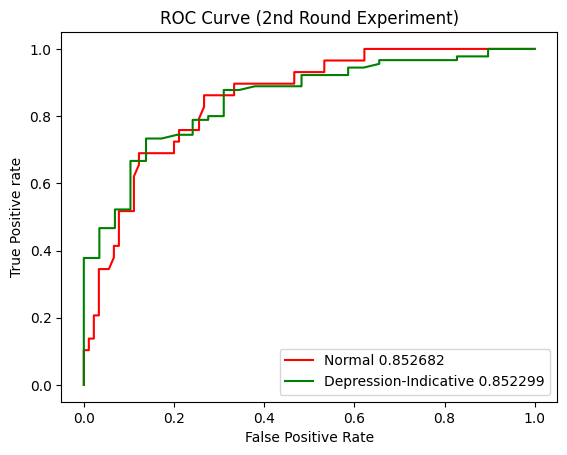

In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc = {}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test.argmax(axis=1), pred_lstm[:,i], pos_label=i)
    roc[i]   = roc_auc_score(y_test[:,i], pred_lstm[:,i], multi_class='ovo')

    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='Red', label= 'Normal '+ str(round(roc[0],6)))
plt.plot(fpr[1], tpr[1], linestyle='solid',color='green', label= 'Depression-Indicative '+ str(round(roc[1],6)))



plt.title('ROC Curve (2nd Round Experiment)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.savefig('ROC Curve (2nd Round Experiment)',dpi=300);

In [50]:
unlabeled = pd.read_csv('/gdrive/MyDrive/pr/unlabeled_remained_after_first_round.csv')

In [51]:
unlabeled

,Unnamed: 0,ID,Texts,labels
0,999,1000,"হ্যালো ফ্রেন্ডস আমি দিশা , সবার নাকাব মুভি টা ...",NaN
1,1000,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,NaN
2,1001,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,NaN
3,1002,1003,"সব ভালোবাসা প্রেম নয় , কিছু ভালোবাসা বন্ধুত্ব...",NaN
4,1003,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",NaN
...,...,...,...,...
2723,3909,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,NaN
2724,3910,3911,আমার মেয়ের জন্য একটি সুন্দর নাম দিন । অর্থসহ ...,NaN
2725,3911,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,NaN
2726,3912,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,NaN


In [52]:
unlabeled.drop(unlabeled.columns[[0]], axis = 1, inplace = True)
unlabeled

,ID,Texts,labels
0,1000,"হ্যালো ফ্রেন্ডস আমি দিশা , সবার নাকাব মুভি টা ...",NaN
1,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,NaN
2,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,NaN
3,1003,"সব ভালোবাসা প্রেম নয় , কিছু ভালোবাসা বন্ধুত্ব...",NaN
4,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",NaN
...,...,...,...
2723,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,NaN
2724,3911,আমার মেয়ের জন্য একটি সুন্দর নাম দিন । অর্থসহ ...,NaN
2725,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,NaN
2726,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,NaN


In [53]:
unlabeled_texts = unlabeled["Texts"].values
#Convert tokenized commnent to sequnces
unlabeled_texts = tokenizer.texts_to_sequences(unlabeled_texts)

 # padding the sequences
unlabeled_texts = pad_sequences(unlabeled_texts, max_len, padding='post')

In [54]:
pred_unlabeled = LSTM_model.predict(unlabeled_texts)

86/86 [==============================] - 4s 47ms/step


In [55]:
print(np.around(pred_unlabeled,3))
print(pred_unlabeled.shape)

[[0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 ...
 [0.994 0.005]
 [0.    1.   ]
 [0.998 0.002]]
(2728, 2)


In [56]:
need_handlabeling = pd.DataFrame(columns=['ID','Texts', 'labels'])

In [57]:
def least_confi(arr):
      
    # get number of rows and columns
    no_of_rows = arr.shape[0]
    no_of_column = arr.shape[1]
    num_labels = 2 
    cnt = 0;
   
    nh_index = 0
    for i in range(no_of_rows):
          
        # Initialize max1 to 0 at beginning
        # of finding max element of each row
        most_conf = 0
        for j in range(no_of_column):
            if arr[i][j] > most_conf :
                most_conf = arr[i][j]
                numerator = (num_labels * (1 - most_conf))
                denominator = (num_labels - 1)
                least_conf = numerator / denominator

                
                  
        # print maximum element of each row
        print(cnt,".",least_conf)
        
        if(least_conf>0.6): #if the confidence score is greater than 0.6, sample requires handlabeling 
          need_handlabeling.loc[nh_index] = unlabeled.iloc[cnt]
          print("Done")
          nh_index = nh_index + 1
        cnt = cnt+1

In [58]:
least_confi(pred_unlabeled)

0 . 1.7881393432617188e-05
1 . 4.470348358154297e-05
2 . 1.9073486328125e-06
3 . 6.842613220214844e-05
4 . 0.0006926059722900391
5 . 0.012102723121643066
6 . 4.0531158447265625e-06
7 . 3.5881996154785156e-05
8 . 0.013385891914367676
9 . 0.0
10 . 0.0
11 . 0.0
12 . 0.009766697883605957
13 . 2.0384788513183594e-05
14 . 5.14984130859375e-05
15 . 2.384185791015625e-06
16 . 0.006055474281311035
17 . 0.0022139549255371094
18 . 0.03824448585510254
19 . 0.00018644332885742188
20 . 0.0
21 . 3.5762786865234375e-07
22 . 5.125999450683594e-06
23 . 1.1920928955078125e-07
24 . 0.00019121170043945312
25 . 0.0
26 . 0.4283255338668823
27 . 0.00019252300262451172
28 . 4.9591064453125e-05
29 . 1.1920928955078125e-07
30 . 0.006550788879394531
31 . 0.0
32 . 1.3113021850585938e-06
33 . 0.02290189266204834
34 . 0.0
35 . 0.00020325183868408203
36 . 0.004201412200927734
37 . 0.001406550407409668
38 . 4.76837158203125e-07
39 . 2.0265579223632812e-06
40 . 0.0005336999893188477
41 . 0.0005513429641723633
42 . 1.78

In [59]:
original_samples = pd.read_csv('/gdrive/MyDrive/pr/unbalanced.csv')

In [60]:
second_round_handlabeling = pd.DataFrame()

In [61]:
second_round_handlabeling = original_samples.loc[original_samples['ID'].isin(need_handlabeling['ID'])]

In [62]:
second_round_handlabeling

,ID,Texts,labels
1103,1104,পোলিং এজেন্টকে ভোটকেন্দ্রে রাখার দায়িত্ব দলেরই :,non_depressive
1105,1106,"কিছু আহ্লাদ , কিছু উচ্ছ্বাস । যা দিয়ে নিজের ছ...",non_depressive
1316,1317,বিয়ের প্রথম বছরঃ জানু দ্বিতীয় বছরঃওগো শুনছ !...,non_depressive
1379,1380,ছোট্ট বিটলুর সাদাকালো জীবনটা রঙিন হয়ে ওঠে উপম...,non_depressive
1409,1410,"অবৈধ পথে ধনী মানুষ সমাজে সম্মানীত , বৈধ পথের গ...",non_depressive
...,...,...,...
3776,3777,এসো এই মুলুকে লতাপাতায় বেষ্টিত এইঘর খানায় । ...,non_depressive
3804,3805,মানুষের মৃত্যুতে শুধুমাত্র কাফন বিক্রেতার মুখে...,non_depressive
3853,3854,স্বার্থক জন্ম আমরা জন্মেছি এই দেশে রাস্তায় মা...,depressive
3898,3899,সুষ্ঠ এবং নির্ভেজাল নির্বাচন দেখতে চান তাইলে ব...,depressive


In [65]:
second_round_handlabeling.to_csv('second_round_handlabeling.csv',sep='\t')

In [63]:
labeled_data_after_first_round = pd.DataFrame()

In [64]:
labeled_data_after_first_round = original_samples.loc[original_samples['ID'].isin(all_labeled['ID'])]

In [65]:
labeled_data_after_first_round

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
3858,3859,"এদের কাছে কোন জিনিস না নিয়ে যাবেন্নাহ , কেননা...",non_depressive
3879,3880,"আয় বিজেপি দেখে যা , দেখবি যত জ্বলবি তত !",depressive
3897,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,depressive
3899,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",depressive


In [66]:
labeled_data_after_first_round.to_csv('labeled_data_after_firstround.csv',sep='\t')

In [69]:
labeled_samples = pd.read_csv('/gdrive/MyDrive/pr/unbalanced.csv')

In [70]:
second_round_handlabeled = pd.DataFrame()

In [71]:
second_round_handlabeled = labeled_samples.loc[labeled_samples['ID'].isin(need_handlabeling['ID'])]

In [72]:
second_round_handlabeled

,ID,Texts,labels
1045,1046,যে অনুসরণ করে সে নানা ছদ্মবেশ ধরে অনুসরণ করবে ...,non_depressive
1077,1078,"আমি জানি আমাকে ছাড়া তুমি ভাল থাকবে , কিন্তু ক...",depressive
1085,1086,বাসা থেকে বিকালে বের হওয়ার আগে চা বানিয়ে ছিল...,non_depressive
1103,1104,পোলিং এজেন্টকে ভোটকেন্দ্রে রাখার দায়িত্ব দলেরই :,non_depressive
1105,1106,"কিছু আহ্লাদ , কিছু উচ্ছ্বাস । যা দিয়ে নিজের ছ...",non_depressive
...,...,...,...
3727,3728,আপনার নাকি ? একটু ছাতা ধরতে ও বেচারা নিজ দলের ...,depressive
3772,3773,সহপাঠী হত্যার বিচারের দাবীতে কুরমিটোলায় রাস্ত...,depressive
3804,3805,মানুষের মৃত্যুতে শুধুমাত্র কাফন বিক্রেতার মুখে...,non_depressive
3898,3899,সুষ্ঠ এবং নির্ভেজাল নির্বাচন দেখতে চান তাইলে ব...,depressive


In [73]:
second_round_handlabeled.to_csv('labeled_data_secondround.csv',sep='\t')